## Titles

The titles included in the bibliography tell us a few things, for instance the language a publication is written in or the main themes (keywords, authors) that is the subject of a publication. 

In [1]:
# === Imports === 

import re 
import seaborn as sns
from matplotlib import pyplot as plt
from os.path import join
from os.path import realpath, dirname
import os
from lxml import etree
from io import StringIO, BytesIO
from collections import Counter
import pandas as pd
import numpy as np


# === Files and parameters === 

bibdatafile = join("data", "BIB18_Zotero-RDF_2024-01-02.rdf") 
#bibdatafile = join(wdir, "data", "BIB18_Zotero-RDF_TEST.rdf") 
stopwords_fra_file = join("results", "stopwords-fra.txt")
stopwords_eng_file = join("results", "stopwords-eng.txt")


namespaces = {
    "foaf" : "http://xmlns.com/foaf/0.1/",
    "bib" : "http://purl.org/net/biblio#",
    "dc" : "http://purl.org/dc/elements/1.1/",
    "z" : "http://www.zotero.org/namespaces/export#",
    "rdf" : "http://www.w3.org/1999/02/22-rdf-syntax-ns#"
    }


# === Load the dataset === 

bibdata = etree.parse(bibdatafile)

## Extracting the titles

The first step is to identify the titles in the dataset. At the moment, the primary titles of journal articles, book chapters and books are taken into account. 

In [2]:
def get_titles(bibdata): 
    """
    Extract all the primary titles from the dataset. 
    Primary titles are all titles except journal names. 
    """
    # Find all primary "title" elements in the dataset 
    titles = []

    # Article titles
    xpath = "//bib:Article/dc:title/text()"
    article_titles = bibdata.xpath(xpath, namespaces=namespaces)
    titles.extend(article_titles)

    # Book titles
    xpath = "//bib:Book/dc:title/text()"
    book_titles = bibdata.xpath(xpath, namespaces=namespaces)
    titles.extend(book_titles)

    # Book chapter titles
    xpath = "//bib:BookSection/dc:title/text()"
    bookchapter_titles = bibdata.xpath(xpath, namespaces=namespaces)
    titles.extend(bookchapter_titles)

    print("Number of titles found: " + str(len(titles)) + ".")
    return titles

# === Main === 

global titles 
titles = get_titles(bibdata)


Number of titles found: 78434.


The following step joins all words in all titles, then filters the list using French and English stopwords.

In [3]:
def load_stopwords(stopwordsfile): 
    with open(stopwordsfile, "r", encoding="utf8") as infile: 
        stopwords = infile.read().split("\n")
    #print(stopwords)
    return stopwords 

    
def get_keywords(titles, stopwords_fra, stopwords_eng): 
    """
    Identify recurring, content-bearing words in the titles. 
    Returns: dict (keyword : frequency)
    """
    
    # Filtering of words in all titles
    titles = " ".join(titles)
    titlewords = re.split("\W+", titles)
    titlewords = [word.lower() for word in titlewords if word.lower() not in stopwords_fra]
    titlewords = [word.lower() for word in titlewords if word.lower() not in stopwords_eng]
    #print(titles[0:20])
    
    # Establish counts, transform to DataFrame, sort to select n most frequent words
    titlewords_counts = dict(Counter(titlewords))
    titlewords_counts = pd.DataFrame.from_dict(
        titlewords_counts, 
        orient="index", 
        columns=["count"]).reset_index().rename({"index" : "word"}, 
        )      
    titlewords_counts.sort_values(by="count", ascending=False, inplace=True)
    titlewords_counts = titlewords_counts[0:50]
   
    #print(titlewords_counts.head())
    return titlewords_counts


global titlewords_counts
stopwords_fra = load_stopwords(stopwords_fra_file)
stopwords_eng = load_stopwords(stopwords_eng_file)
titlewords_counts = get_keywords(titles, stopwords_fra, stopwords_eng)

The following step provides a visualization of the most frequently used words in the titles. 

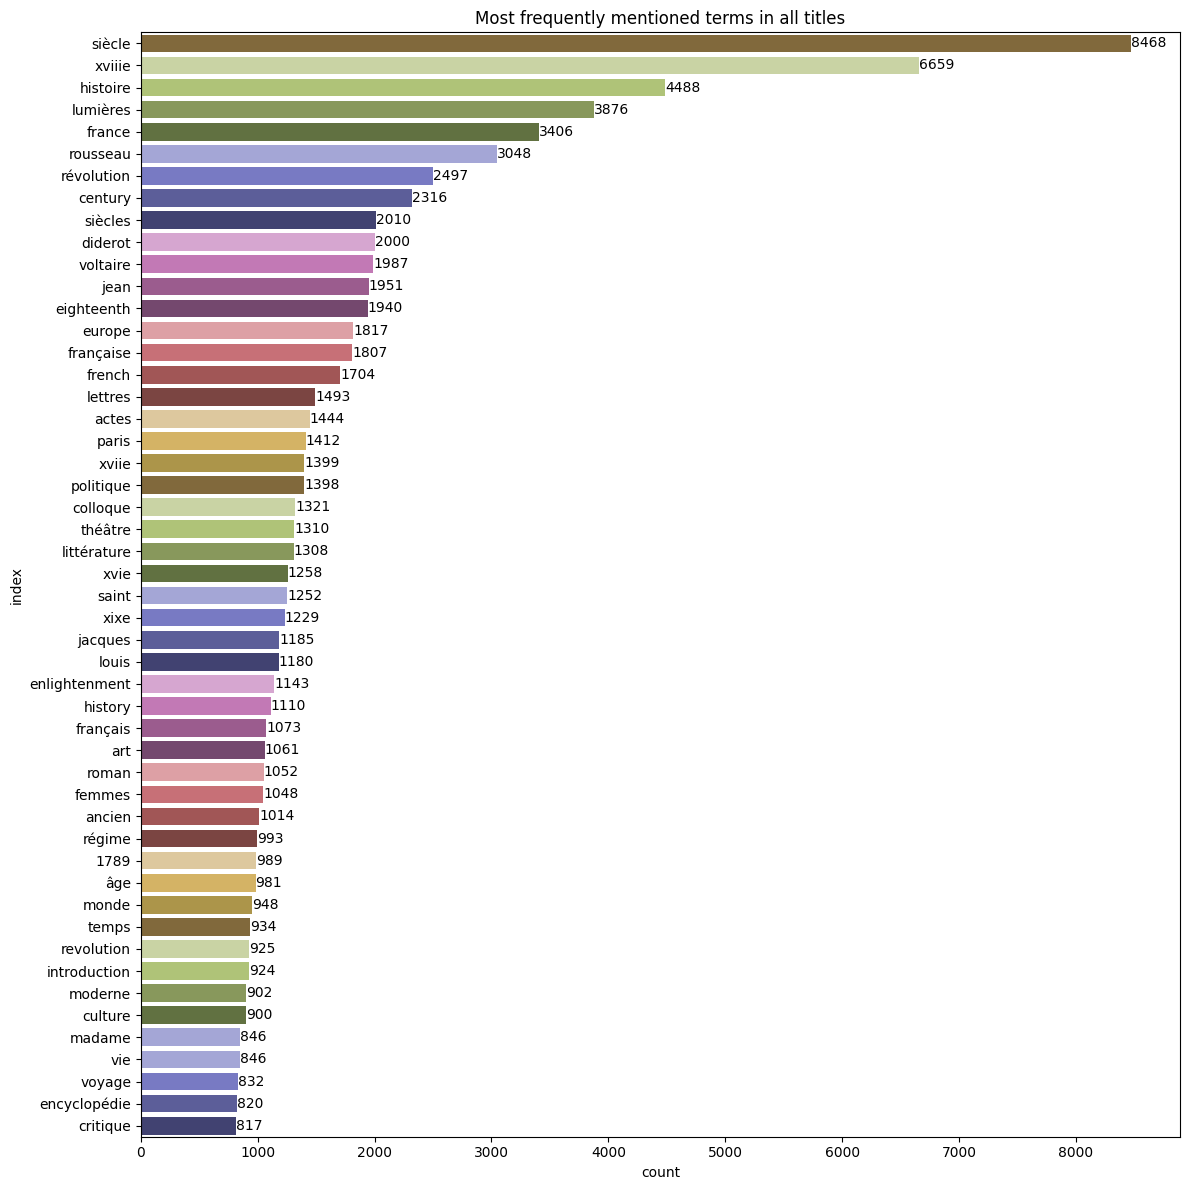

In [6]:
def visualize_titlewords(titlewords_counts): 
    plt.figure(figsize=(12,12))
    palette = sns.color_palette("tab20b", len(titlewords_counts)-1)
    fig = sns.barplot(
        data=titlewords_counts, 
        y="index", 
        x="count", 
        hue = "count",
        legend = False,
        palette = palette,
        orient='h' 
        )
    for i in fig.containers:
        fig.bar_label(i,)
    fig.set(title="Most frequently mentioned terms in all titles")
    plt.tight_layout()
    plt.savefig(
        join("figures", "titlewords_counts.svg"),
        dpi=600
        )
    
visualize_titlewords(titlewords_counts)

As can be seen from this table, there are a few authors who appear with particularly high frequency in the titles: Rousseau, Voltaire, Diderot (in descending order). 

In terms of thematic keywords, apart from indicators of the time period and geographic focus, the following terms stand out (again, in descending order of frequency): histoire, Lumières, révolution, lettres, history, Europe, Enlightenment, art, théâtre, revolution, roman, littérature, correspondance, voyage, culture, etc. 